# Prepare functions

# Setup

In [1]:
import sys
sys.path.insert(1, '/users/genomics/xoel/canonades/bioinforgalician/src/python/celloracle')

In [2]:
import os

subset = 'NeuralPCW21'
os.chdir(f'/users/genomics/xoel/codebases/co_new/data/{subset}/')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [3]:
import scanpy as sc
sc.set_figure_params(
    scanpy=True,
    dpi=80, 
    dpi_save=300, 
    frameon=True,
    vector_friendly=True, 
    fontsize=14, 
    figsize=None, 
    color_map=None,
    facecolor=None, 
    transparent=False, 
    ipython_format='png2x')
sc.settings.verbosity=4
sc.settings.autosave=True
sc.settings.autoshow=True

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [4]:
n_cores = min(int(os.getenv('SLURM_CPUS_PER_TASK')) -4 or 18, 96)


# **Part 1 //** Create a gene regulatory network (GRN)

## Find ATAC coaccessible peaks

In [24]:
from cicero_helper import create_cicero_cmd

In [4]:
os.listdir()

['ATAC.peak_metadata.tsv',
 'temp_cicero.sh',
 'cicero_connections.rds',
 'ATAC.unprocessed.tsv',
 'cicero_peaks.csv',
 'cicero_connections.csv',
 'Rplots.pdf',
 'RNA.unprocessed.h5ad',
 'ATAC.cell_metadata.tsv',
 'log.test.txt',
 'cicero_umap.pdf']

In [5]:
r_cmd = create_cicero_cmd( 
    atac_path='ATAC.unprocessed.tsv',
    peaks_bed_path='ATAC.peak_metadata.tsv',
    cell_metadata_path='ATAC.cell_metadata.tsv', 
    plot_by='cell.type', 
    R_quote='',
    str_quote="\'",
    save_dir='./', 
    prefix=None, 
    verbose='TRUE')

with open('temp_cicero.sh', 'wt') as f:
    f.writelines(r_cmd)
print(r_cmd)

source('/users/genomics/xoel/canonades/bioinforgalician/src/python/celloracle/cicero.R',echo=TRUE)

pipe_cicero_conns(atac_path='ATAC.unprocessed.tsv',peaks_bed_path='ATAC.peak_metadata.tsv',cell_metadata_path='ATAC.cell_metadata.tsv',plot_by='cell.type',save_dir='./',prefix=NULL,verbose=TRUE)


In [6]:
%%bash -s "$r_cmd" "$subset"
eval "$(micromamba shell hook --shell=bash)"
micromamba activate ~/venvs/cicero
# LOCAL
# Rscript --vanilla --verbose ./temp_cicero.sh
# sbatch --job-name=$2 --output=log.test.txt --mem=185GB --time=4-00:00:00 --partition=normal,long,bigmem --cpus-per-task=20 --wrap="Rscript --vanilla --verbose ./temp_cicero.sh"

In [7]:
# !while [ 1 ]; do tail log.test.txt; sleep 30; clear; done
!cat log.test.txt | grep -v 'chr1' |  tail -20

Overlap QC metrics:
Cells per bin: 50
Maximum shared cells bin-bin: 44
Mean shared cells bin-bin: 0.339360268674543
Median shared cells bin-bin: 0
[2] Running cicero analysis
[1] "Starting Cicero"
[1] "Calculating distance_parameter value"
[1] "Running models"
[1] "Assembling connections"
[1] "Successful cicero models:  9577"
[1] "Other models: "

  Too many elements in range Zero or one element in range 
                        1135                         2388 
[1] "Models with errors:  0"
[1] "Done"
[SAVE] Saving connections & peaks
                          Peak1                     Peak2      coaccess
 [ reached 'max' / getOption("max.print") -- omitted 102548307 rows ]


In [8]:
!rm ./temp_cicero.sh

## Run motif analysis and filter

In [9]:
import cicero_to_grn 

Adding to PATH: /soft/system/software/BEDTools/2.30.0-GCC-10.2.0/bin


In [10]:
os.listdir()

['ATAC.peak_metadata.tsv',
 'cicero_connections.rds',
 'ATAC.unprocessed.tsv',
 'cicero_peaks.csv',
 'cicero_connections.csv',
 'Rplots.pdf',
 'RNA.unprocessed.h5ad',
 'ATAC.cell_metadata.tsv',
 'log.test.txt',
 'cicero_umap.pdf']

In [12]:
grn_result = cicero_to_grn.run_motif_analysis(
    peaks_csv='cicero_peaks.csv',
    connections_csv='cicero_connections.csv',
    
    extra_peaks=None,
    ref_genome='hg38',
    provider='UCSC',
    frp=0.02,
    coacc_thres=0.8,
    motifs=None,
    motif_score_thres=8,
    save_dir='./',
    prefix=None,
    verbose=True
)

[1] Loading peaks and connections
[2] Loading genome
hg38 is installed.
[3] Integrating peaks, connections and genome
que bed peaks: 654446
tss peaks in que: 44637
[4] Filtering peaks by coaccessibility (0.8)
Over threshold: 2.34 %
[5] Extracting peaks
[6] Performing motif scan (frp: 0.02)
No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 

Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



scanning:   0%|          | 0/40244 [00:00<?, ? sequences/s]

[7] Filtering motif score (motif_score_thres)
Over threshold: 49.66 %
Filtering finished: 11150364 -> 4125776
1. Converting scanned results into one-hot encoded dataframe.


  0%|          | 0/40244 [00:00<?, ?it/s]

2. Converting results into dictionaries.


  0%|          | 0/20001 [00:00<?, ?it/s]

  0%|          | 0/1098 [00:00<?, ?it/s]

[8] Saving results


  0%|          | 0/3 [00:00<?, ?it/s]

# **Part 2 //** Prepare RNA data

In [5]:
import scanpy as sc
import prepare_rna
%matplotlib inline

In [6]:
sorted(os.listdir())

['.ipynb_checkpoints',
 'ATAC.cell_metadata.tsv',
 'ATAC.peak_metadata.tsv',
 'ATAC.unprocessed.tsv',
 'Gradient.Perturbation.celloracle.gradient',
 'Links.Perturbation.celloracle.links',
 'Links.celloracle.links',
 'Oracle.Perturbation.celloracle.oracle',
 'Oracle.celloracle.oracle',
 'RNA.processed.h5ad',
 'RNA.unprocessed.h5ad',
 'RootCellSelection.html',
 'Rplots.pdf',
 'base_grn.coaccessibility=0.8.score=8.base_grn.parquet',
 'celloracle_tfinfo.coaccessibility=0.8.score=8.celloracle.tfinfo',
 'cicero_connections.csv',
 'cicero_connections.rds',
 'cicero_peaks.csv',
 'cicero_umap.pdf',
 'cluster_GRN',
 'coaccessible_peaks.coaccessibility=0.8.csv',
 'figures',
 'log.test.txt',
 'network_plots',
 'perturbations']

In [7]:
adata_file = 'RNA.unprocessed.h5ad'
adata_complete = sc.read_h5ad(adata_file)

In [8]:
dict(
    RGCmaturationExtended = 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
    RGCmaturation = 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
    NeuralPCW16 = 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
    NeuralPCW20 = 'hft_w20_p3_r1_AATGACCTCTACCAGA',
    # NeuralPCW21 = 'hft_w21_p5_r2_GGGTTGCAGCTCTCGG',
    NeuralPCW21 = 'hft_w21_p5_r1_GTTCTCGAGGGAACGG',
    Gliogenesis = 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
    GliogenesisExtended = 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
)

{'RGCmaturationExtended': 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
 'RGCmaturation': 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
 'NeuralPCW16': 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
 'NeuralPCW20': 'hft_w20_p3_r1_AATGACCTCTACCAGA',
 'Gliogenesis': 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
 'GliogenesisExtended': 'hft_w16_p7_r2_TGGAGAGAGAGGACTC'}

### PIPE [1] PREPROCESSING DATA


  0%|          | 0/8 [00:00<?, ?it/s]

[1] Saving raw counts
[2] Computing QC
[3] Filtering genes: total_counts > 1
[4] Normalizing per cell using total_counts
normalizing by total count per cell
    finished (0:00:03): normalized adata.X and added    'total_counts', counts per cell before normalization (adata.obs)
[5] Computing highly variable genes and filtering to top 3000
(6455, 16642)
extracting highly variable genes
    the 3000 top genes correspond to a normalized dispersion cutoff of 1.5152040719985962
    finished (0:00:00)


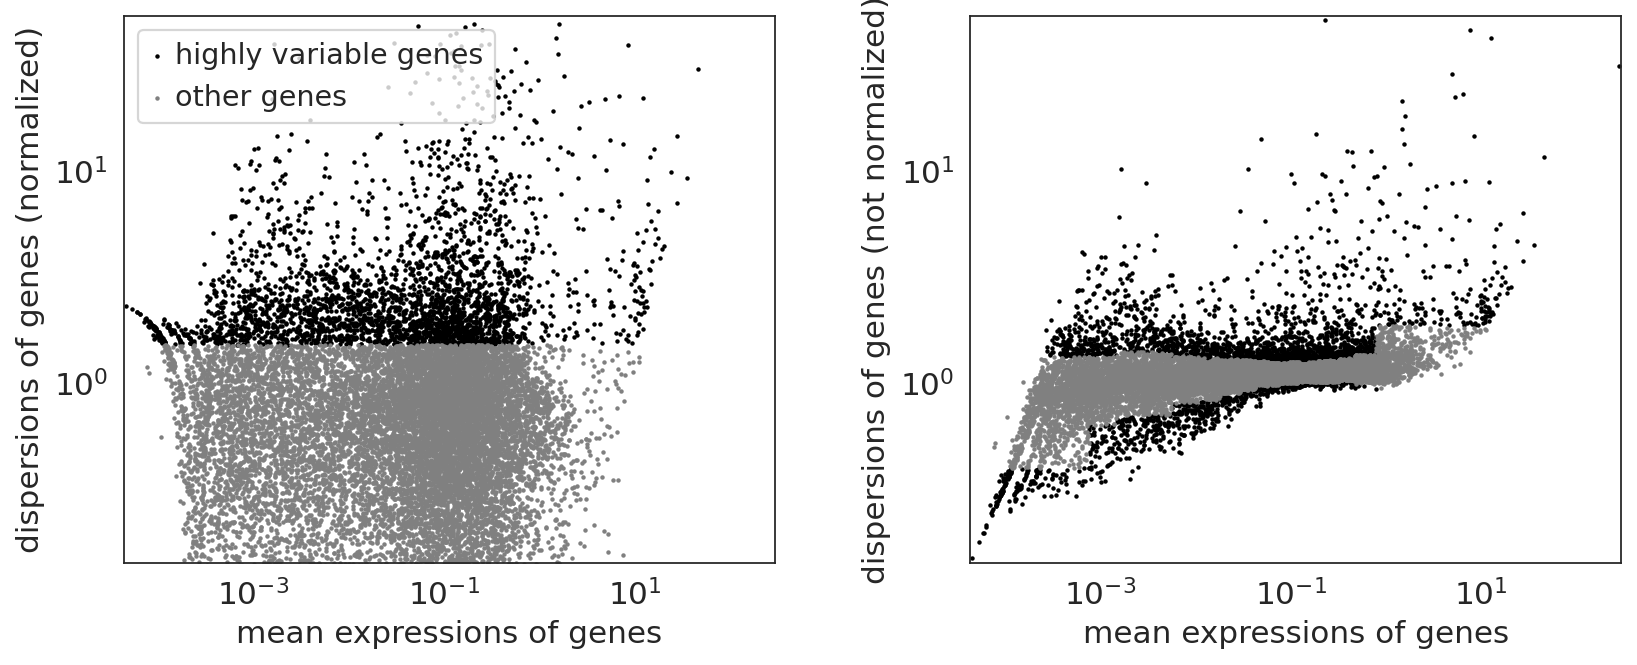

(6455, 2999)
[6] Normalizing per cell again using total_counts
normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'total_counts', counts per cell before normalization (adata.obs)
[7] Log1p transformation
[8] Scaling
### PIPE [2] EMBEDDING DATA


  0%|          | 0/8 [00:00<?, ?it/s]

[1] Computing PCA
computing PCA
    with n_comps=50
    finished (0:00:01)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


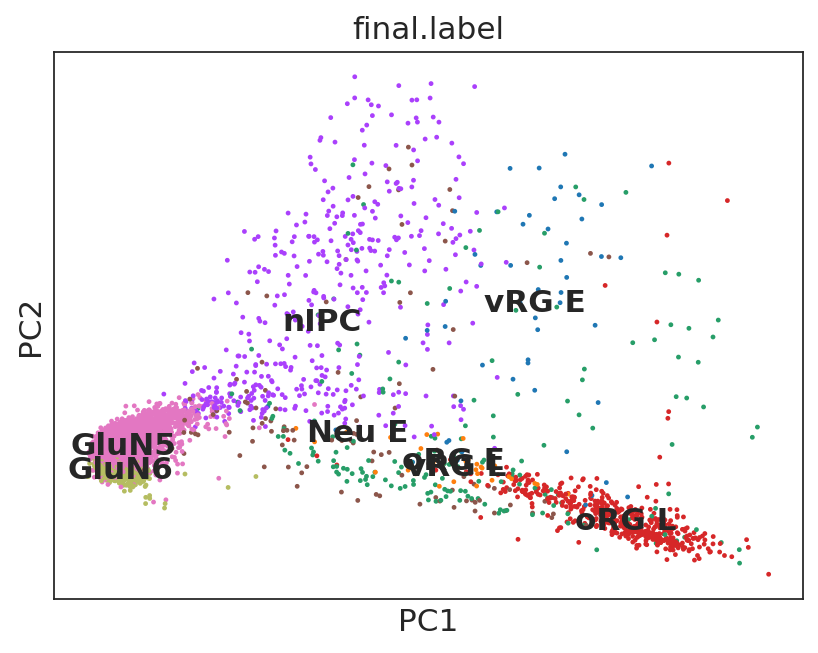

[2] Computing neighbors
computing neighbors
    computing neighbors
    computed neighbors (0:00:00)
    computed connectivities (0:00:08)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
[3] Computing diffusion map
computing Diffusion Maps using n_comps=30(=n_dcs)
        initialized `.distances` `.connectivities` 
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99781084 0.9938442  0.9917986  0.98739225 0.98393846
     0.9793948  0.976186   0.9693396  0.9671564  0.9630747  0.9587624
     0.9510432  0.9498137  0.9488126  0.9385796  0.9358362  0.9337354
     0.93249136 0.9285425  0.92506903 0.9177199  0.9142537  0.9116581
     0.9045378  0.9018835  0.9007855  0.89728343 0.89522296 0.8890624 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix

  0%|          | 0/500 [00:00<?, ?it/s]

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


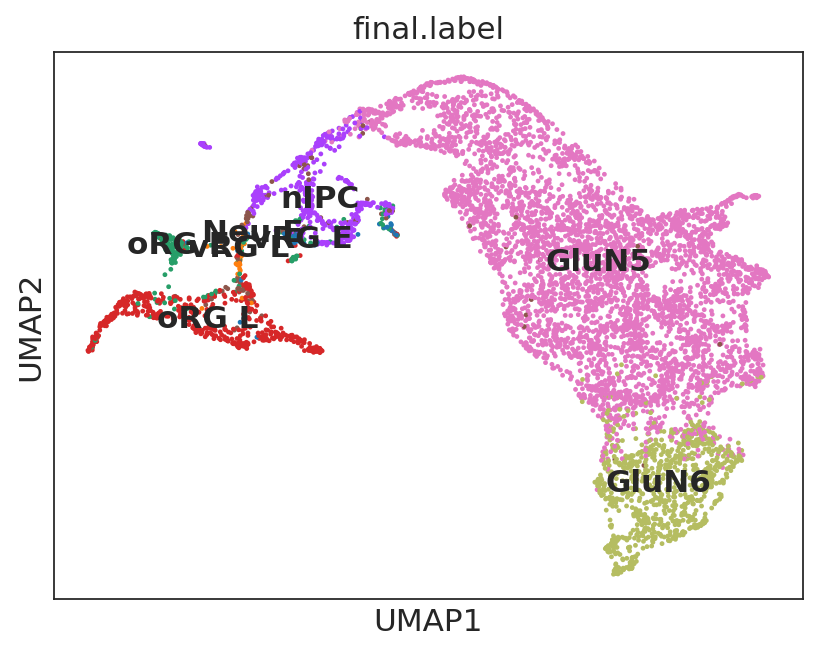

[6] Constructing PAGA graph (1/2)
running PAGA
        initialized `.distances` `.connectivities` `.eigen_values` `.eigen_basis` `.distances_dpt`
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


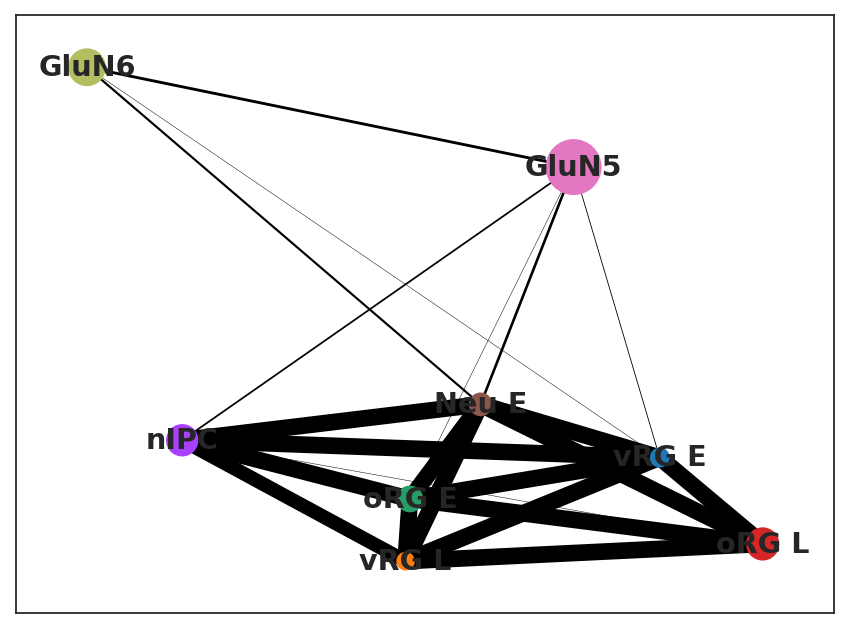

[7] Constructing PAGA graph (2/2)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:33)


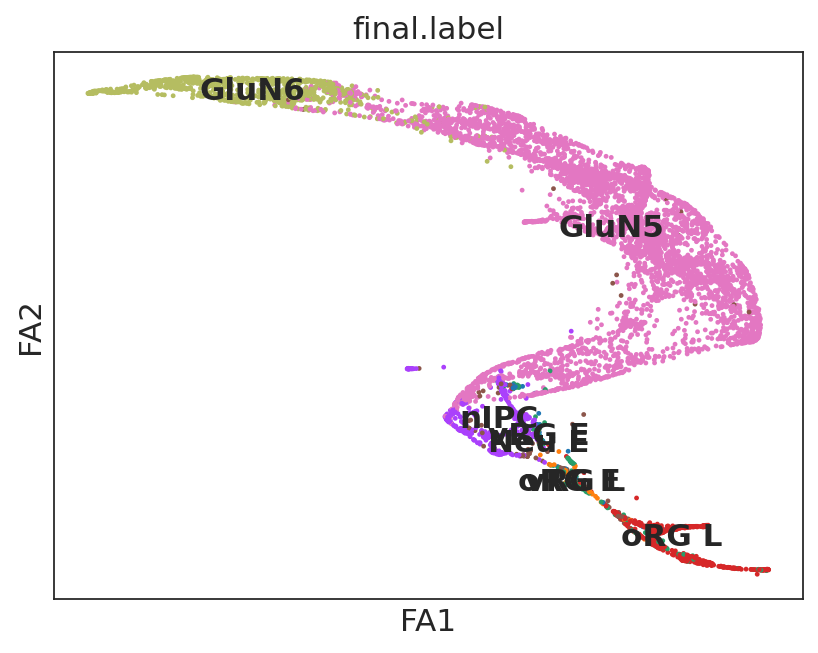

[8] Constructing PHATE graph
X_scvi
Running on X_scvi obsm
Calculating PHATE...
  Running PHATE on 6455 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 1.45 seconds.
    Calculating affinities...
    Calculated affinities in 1.76 seconds.
  Calculated graph and diffusion operator in 3.34 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 3.83 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.07 seconds.
  Calculated landmark operator in 8.09 seconds.
  Calculating optimal t...
    Automatically selected t = 13
  Calculated optimal t in 0.93 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.20 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.97 seconds.
Calculated PHATE in 16.55 seconds.


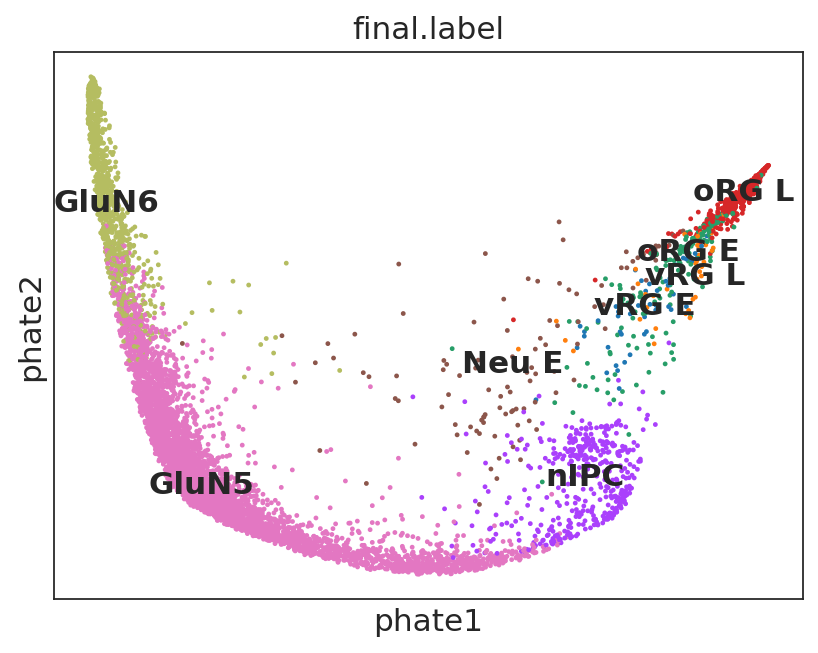

### PIPE [3] COMPUTING PSEUDOTIME


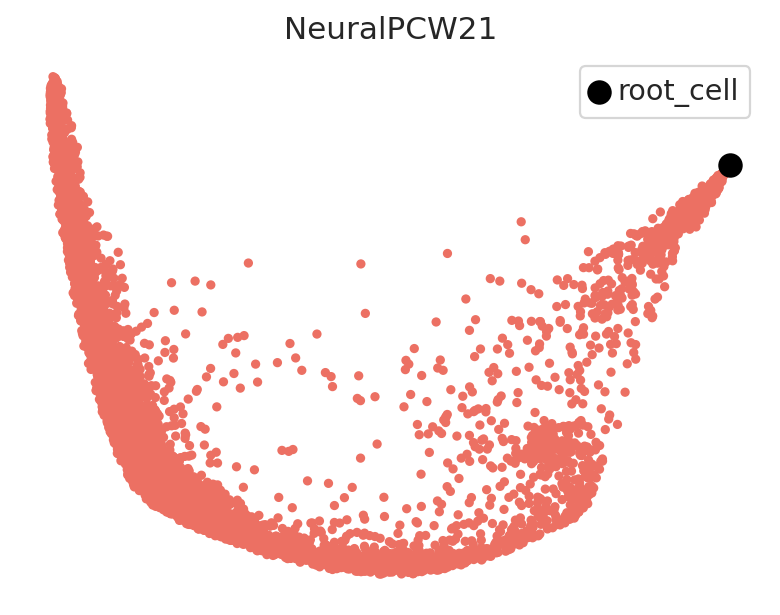

        initialized `.distances` `.connectivities` `.eigen_values` `.eigen_basis` `.distances_dpt`
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


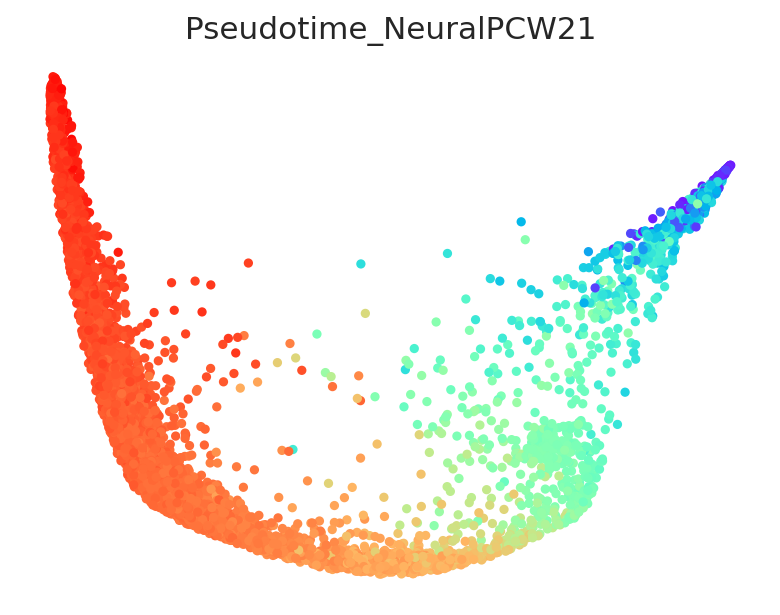

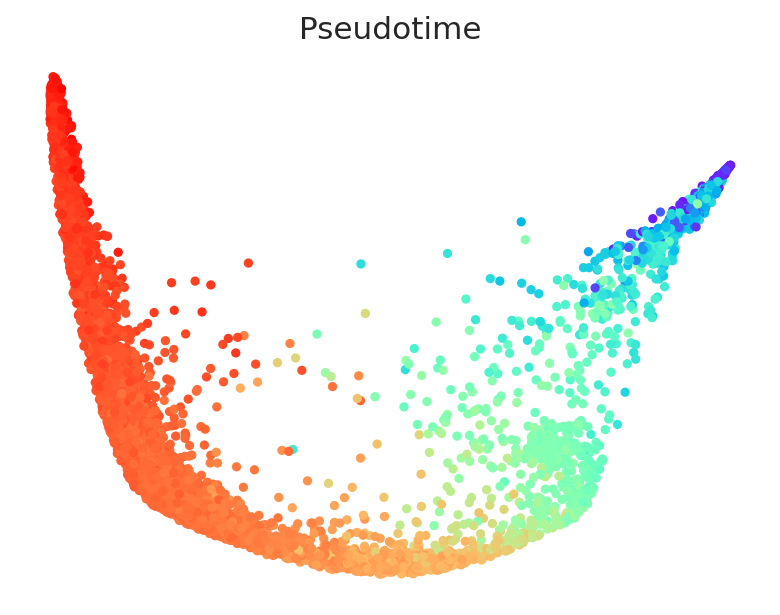

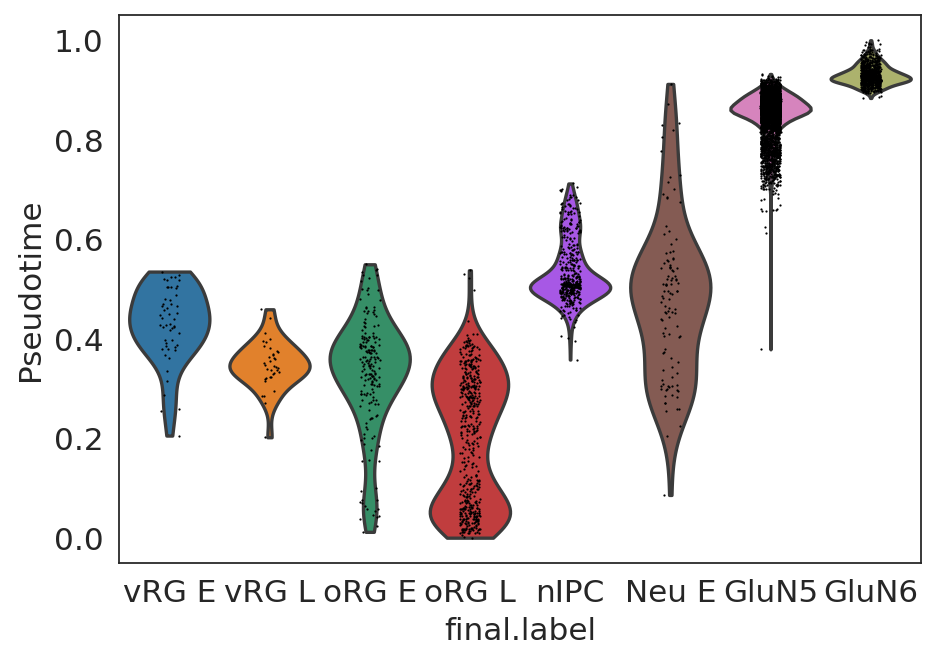

### PIPE [4] SAVING DATA


In [8]:
adata = prepare_rna.prepare_adata(
    
    adata_complete,
    group_by='final.label',
    save_dir='./',
    
    min_total_counts_per_cell=1,
    key_n_counts='total_counts',
    n_top_genes=3000,


    nn_1_n_neighbors=20,
    nn_1_use_rep='X_pca',
    nn_1_n_pcs=10,
    dm_n_comps=30,
    nn_2_n_neighbors=100,

    phate_run_on='X_scvi',
    phate_knn=100, 
    phate_n_pca=30, 
    phate_decay=15, 
    phate_t='auto',
    
    skip_umap=False,
    skip_paga=False,
    skip_phate=False,
    random_state=None,    

    root_cells='hft_w21_p5_r1_GTTCTCGAGGGAACGG',
    lineages=None, 
    lineage_name=subset,
    embedding_key='X_phate',
    # embedding_key='X_draw_graph_fa',
    verbose=True)

# **Part 3 //** Fit GRN to expression

In [9]:
import network_fit

In [10]:
sorted(os.listdir())

['.ipynb_checkpoints',
 'ATAC.cell_metadata.tsv',
 'ATAC.peak_metadata.tsv',
 'ATAC.unprocessed.tsv',
 'Gradient.Perturbation.celloracle.gradient',
 'Links.Perturbation.celloracle.links',
 'Links.celloracle.links',
 'Oracle.Perturbation.celloracle.oracle',
 'Oracle.celloracle.oracle',
 'RNA.processed.h5ad',
 'RNA.unprocessed.h5ad',
 'RootCellSelection.html',
 'Rplots.pdf',
 'base_grn.coaccessibility=0.8.score=8.base_grn.parquet',
 'celloracle_tfinfo.coaccessibility=0.8.score=8.celloracle.tfinfo',
 'cicero_connections.csv',
 'cicero_connections.rds',
 'cicero_peaks.csv',
 'cicero_umap.pdf',
 'cluster_GRN',
 'coaccessible_peaks.coaccessibility=0.8.csv',
 'figures',
 'log.test.txt',
 'network_plots',
 'perturbations']

In [11]:
oracle, links = network_fit.network_fit_pipe(
    adata_fname = 'RNA.processed.h5ad',
    base_GRN_fname = 'base_grn.coaccessibility=0.8.score=8.base_grn.parquet',
    cluster_column_name = 'final.label',
    max_n_pcs = 50,
    links_alpha=10,
    
    embedding_name='X_phate',
    
    tempdir=f'/scratch/{subset}/tmp/',

    links_pval=0.001,
    links_top_n_coef=2000,
    seed = 4,
    verbose = True,
    save_dir='./',
    test_mode=False)

  0%|          | 0/7 [00:00<?, ?it/s]

[1] Reading data
Loading adata
Loading GRN
[2] Prepairing oracle object


  0%|          | 0/4 [00:00<?, ?it/s]

[1] Instatiating Oracle with raw RNA-Seq data
    Expression range: count     6455.000000
mean      2354.329590
std       1714.383057
min        250.000000
25%       1417.000000
50%       1789.000000
75%       2479.000000
max      15604.000000
dtype: float64
[2] Adding GRN data to Oracle
[3] Computing and selecting PCs and k for neighbors
[4] Computing KNNs:
    n cells: 6455
    k: 161
    oracle.knn_imputation(n_pca_dims=n_comps, k=161, balanced=True, b_sight=1288, b_maxl=644, n_jobs=-1)
Oracle object

Meta data
    celloracle version used for instantiation: 0.12.0
    n_cells: 6455
    n_genes: 2999
    cluster_name: final.label
    dimensional_reduction_name: X_phate
    n_target_genes_in_TFdict: 20001 genes
    n_regulatory_in_TFdict: 1098 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 152 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 2681 genes
    k_for_knn_imputation: 161
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn i

  0%|          | 0/8 [00:00<?, ?it/s]

Inferring GRN for GluN5...


  0%|          | 0/2681 [00:00<?, ?it/s]

Inferring GRN for GluN6...


  0%|          | 0/2681 [00:00<?, ?it/s]

Inferring GRN for Neu E...


  0%|          | 0/2681 [00:00<?, ?it/s]

Inferring GRN for nIPC...


  0%|          | 0/2681 [00:00<?, ?it/s]

Inferring GRN for oRG E...


  0%|          | 0/2681 [00:00<?, ?it/s]

Inferring GRN for oRG L...


  0%|          | 0/2681 [00:00<?, ?it/s]

Inferring GRN for vRG E...


  0%|          | 0/2681 [00:00<?, ?it/s]

Inferring GRN for vRG L...


  0%|          | 0/2681 [00:00<?, ?it/s]

[4] Checking links
All fits are valid.
[5] Postprocessing links
[6] Scoring genes


  0%|          | 0/8 [00:00<?, ?it/s]

/scratch/NeuralPCW21/tmp/49/44/scratch/NeuralPCW21/tmp/49/32

/scratch/NeuralPCW21/tmp/49/55/scratch/NeuralPCW21/tmp/49/63/scratch/NeuralPCW21/tmp/49/34/scratch/NeuralPCW21/tmp/49/88/scratch/NeuralPCW21/tmp/49/52




/scratch/NeuralPCW21/tmp/49/41
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R



Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

Attaching package: ‘igraph’
    decompose, spectrum


The following objects are masked from ‘package:stats’:
The following object is masked from ‘package:base’:

    decompose, spectrum

    union

The following object is masked from ‘package:base’:


    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following 

[7] Saving results
- Saving raw links per cluster


  0%|          | 0/8 [00:00<?, ?it/s]

- Saving filtered links per cluster


  0%|          | 0/8 [00:00<?, ?it/s]

- Saving processed links
- Saving oracle


In [12]:
%matplotlib Agg
network_fit.pipe_plots(links)

  0%|          | 0/5 [00:00<?, ?it/s]

GluN5
GluN6
Neu E
nIPC
oRG E
oRG L
vRG E
vRG L


  0%|          | 0/8 [00:00<?, ?it/s]

degree_centrality_all
eigenvector_centrality


  0%|          | 0/3 [00:00<?, ?it/s]

Genes in filtered network: 891


  0%|          | 0/891 [00:00<?, ?it/s]

ABHD3
ACAA2
ACAT2
ACSBG1
ACTB
ACTG1
ADCY1
ADGRG1
ADGRV1
ADRA2A
AFF3
AIF1L
AKAP12
AKAP9
ALDH6A1
ALDOC
ANK3
ANKRD9
ANP32E
ANXA1
ANXA2
ANXA5
ANXA7
AP2B1
APOE
AQP4
AQR
ARC
ARHGAP11A
ARHGAP18
ARHGAP5
ARID3A
ARID5B
ARL6IP1
ARPP21
ARX
ASCL1
ASF1B
ASPM
ASXL3
ATAD1
ATAD2
ATAD5
ATCAY
ATF3
ATF5
ATOH7
ATOH8
ATP1A2
ATP1B2
ATP2B1
ATP6V1G2
ATP8A2
AURKA
AURKB
B2M
B3GAT2
BACH2
BASP1
BBX
BCAN
BCL11A
BCL11B
BCL3
BDH2
BDP1
BHLHE22
BHLHE41
BIRC5
BMP7
BNIP3
BOC
BRCA1
BRCA2
BTBD8
BTG1
BTG2
BTG3
BUB1
BUB1B
C14orf132
C16orf74
C1QL2
C1orf122
C2orf72
CA12
CA2
CACNA2D1
CADM2
CALM1
CAMK1D
CAMK4
CARHSP1
CASP3
CASP8AP2
CBLN2
CCBE1
CCDC18
CCDC34
CCN1
CCNA1
CCNA2
CCNB1
CCNB2
CCND2
CCNE2
CCNF
CCNI
CCNL1
CCSAP
CD24
CD63
CD9
CDC123
CDC20
CDCA3
CDCA5
CDCA7
CDCA8
CDH11
CDK1
CDKN2C
CDKN3
CDO1
CEBPD
CELF5
CENPA
CENPB
CENPE
CENPF
CENPH
CENPK
CENPM
CENPU
CEP126
CEP290
CEP55
CHCHD1
CHD7
CHEK1
CHL1
CKAP2
CKAP2L
CKB
CKS2
CLDN10
CLMP
CLSPN
CLU
CLVS1
CNN3
CNTNAP2
COL11A1
COL9A2
CORO1C
CREB3L1
CREB5
CRH
CRYAB
CRYM
CSPG5
CSRNP3
CSRP2

  0%|          | 0/891 [00:00<?, ?it/s]

()

# **Part 4 //** Perturbation analysis

In [13]:
import perturbations

In [14]:
sorted(os.listdir())

['.ipynb_checkpoints',
 'ATAC.cell_metadata.tsv',
 'ATAC.peak_metadata.tsv',
 'ATAC.unprocessed.tsv',
 'Gradient.Perturbation.celloracle.gradient',
 'Links.Perturbation.celloracle.links',
 'Links.celloracle.links',
 'Oracle.Perturbation.celloracle.oracle',
 'Oracle.celloracle.oracle',
 'RNA.processed.h5ad',
 'RNA.unprocessed.h5ad',
 'RootCellSelection.html',
 'Rplots.pdf',
 'base_grn.coaccessibility=0.8.score=8.base_grn.parquet',
 'celloracle_tfinfo.coaccessibility=0.8.score=8.celloracle.tfinfo',
 'cicero_connections.csv',
 'cicero_connections.rds',
 'cicero_peaks.csv',
 'cicero_umap.pdf',
 'cluster_GRN',
 'coaccessible_peaks.coaccessibility=0.8.csv',
 'figures',
 'log.test.txt',
 'network_plots',
 'perturbations']

In [15]:
%matplotlib inline

In [16]:
# o = perturbations.co.load_hdf5('Oracle.celloracle.oracle')

# knn = o.adata.obs['final.label'].value_counts().min()-2
# knn

In [17]:
knn = 35

  0%|          | 0/7 [00:00<?, ?it/s]

[1] Loading data
[2] Re-filtering links
[3] Getting TF dict
[4] Fitting for simulation


  0%|          | 0/8 [00:00<?, ?it/s]

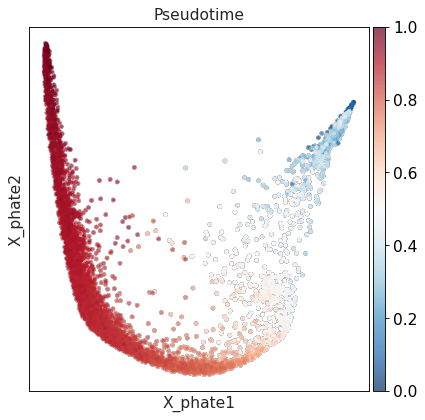

[5] Computing grid p_mass
[6] Transferring pseudotime to grid
KNN pseudotime-transfer model


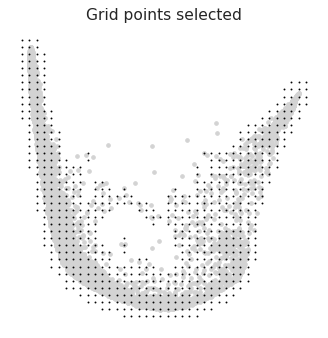

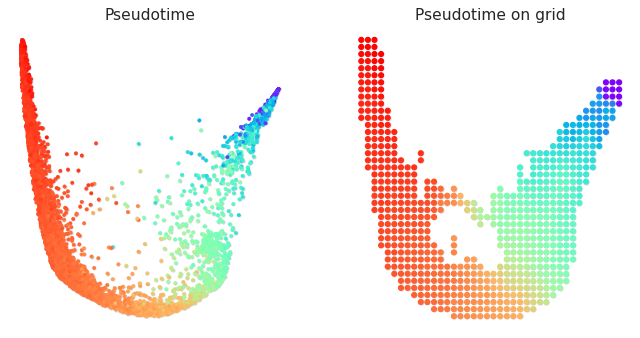

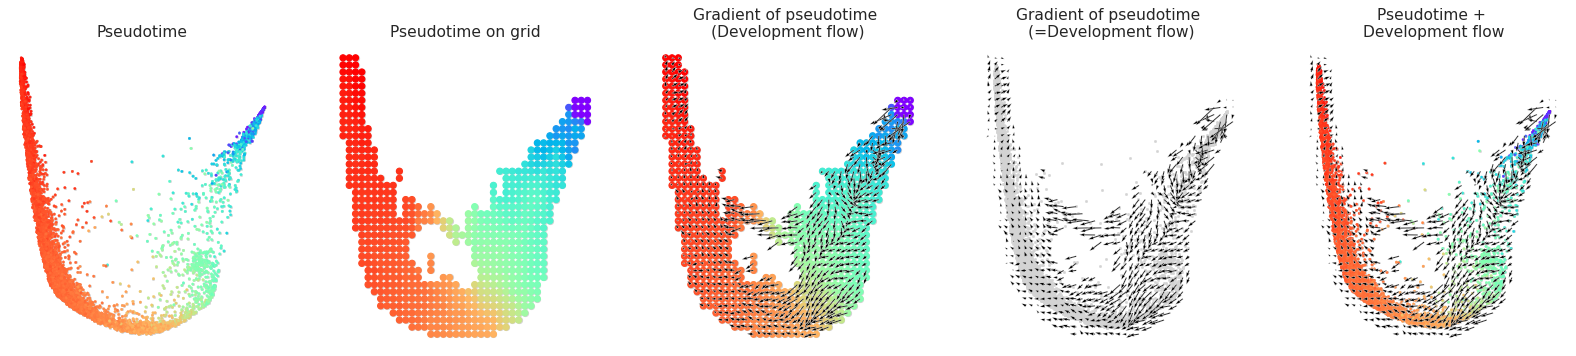

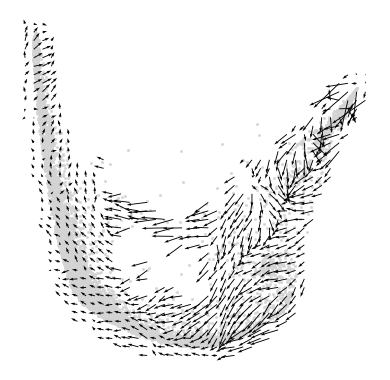

[7] Saving data
	Links
	Oracle
	Gradient


In [18]:
oracle, links, gradient = perturbations.prepare_data(
    oracle_fname='./Oracle.celloracle.oracle', 
    links_fname='./Links.celloracle.links',
    
    palette = None,
    group_by = None,
    
    grn_fit_ridge_alpha = 10,
    
    p_mass_smooth = 0.8,
    p_mass_n_grid = 40,
    p_mass_n_neighbors = knn,
    p_mass_filter_min = 5e2,   

    method='knn',
    n_knn=knn,
    n_poly=3,
    scale_dev = 30,
    s=5,
    
    # save_dir=None,
    save_dir='./',
    prefix=None,
    verbose=True)

In [19]:
groups = {
    'vRG': ['vRG E', 'vRG L'],
    'vtRG': ['vRG E', 'vRG L', 'tRG'],
    'oRG': ['oRG E', 'oRG L'],
    'RG E': ['vRG E', 'vRG E'],
    'RG L': ['vRG E', 'vRG L'],
    'RGC': ['vRG E','vRG L','tRG','oRG E','oRG L'],
    'Neural': ['Neu E', 'nIPC', 'GluN5', 'GluN6'],
    'GluN': ['GluN5', 'GluN6']
}

# oracle.adata.obs['final.label'].cat.categories

### KO simulation

In [20]:
%matplotlib Agg
# %matplotlib inline

In [21]:
ps_sums = perturbations.run_systemic_simulation_async(oracle, gradient, groups=groups, 
                                                      # genes=['EOMES'],
                                                      
                                                      p_mass_smooth=0.8,
                                                      p_mass_n_grid=40,
                                                      p_mass_n_neighbors=knn,
                                                      p_mass_filter_min=5e2,
                                                      
                                                      
                                                      n_cores=n_cores, n_parallel_genes=1, overwrite=True)

Excluding: []
Selected number of neighbors: 37


  0%|          | 0/150 [00:00<?, ?it/s]

perturbation_hdf5/KO.ARID3A.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ARID3A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID3A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID3A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID3A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID3A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID3A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID3A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID3A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID3A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID3A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID3A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID3A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID3A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID3A.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ARID5B.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ARID5B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID5B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID5B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID5B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID5B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID5B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID5B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID5B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID5B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID5B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID5B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID5B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID5B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARID5B.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ARX.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ARX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ARX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ASCL1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ASCL1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ASCL1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ASCL1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ASCL1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ASCL1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ASCL1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ASCL1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ASCL1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ASCL1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ASCL1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ASCL1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ASCL1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ASCL1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ASCL1.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ATF3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ATF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF3.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ATF5.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ATF5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATF5.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ATOH7.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ATOH7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH7.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ATOH8.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ATOH8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ATOH8.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.BACH2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.BACH2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BACH2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BACH2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BACH2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BACH2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BACH2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BACH2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BACH2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BACH2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BACH2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BACH2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BACH2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BACH2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BACH2.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.BBX.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.BBX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BBX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BBX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BBX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BBX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BBX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BBX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BBX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BBX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BBX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BBX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BBX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BBX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BBX.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.BCL11A.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.BCL11A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11A.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.BCL11B.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.BCL11B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11B.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL11B.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.BCL3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.BCL3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BCL3.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.BDP1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.BDP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BDP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BDP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BDP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BDP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BDP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BDP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BDP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BDP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BDP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BDP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BDP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BDP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BDP1.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.BHLHE22.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.BHLHE22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE22.cellorac

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.BHLHE41.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.BHLHE41.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE41.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE41.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE41.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE41.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE41.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE41.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE41.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE41.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE41.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE41.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE41.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE41.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BHLHE41.cellorac

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.BRCA1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.BRCA1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BRCA1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BRCA1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BRCA1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BRCA1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BRCA1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BRCA1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BRCA1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BRCA1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BRCA1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BRCA1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BRCA1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BRCA1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.BRCA1.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.CEBPD.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.CEBPD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CEBPD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CEBPD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CEBPD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CEBPD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CEBPD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CEBPD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CEBPD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CEBPD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CEBPD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CEBPD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CEBPD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CEBPD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CEBPD.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.CENPB.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.CENPB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CENPB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CENPB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CENPB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CENPB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CENPB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CENPB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CENPB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CENPB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CENPB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CENPB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CENPB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CENPB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CENPB.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.CREB3L1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.CREB3L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB3L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB3L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB3L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB3L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB3L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB3L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB3L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB3L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB3L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB3L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB3L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB3L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB3L1.cellorac

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.CREB5.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.CREB5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CREB5.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.CTCFL.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.CTCFL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CTCFL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CTCFL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CTCFL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CTCFL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CTCFL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CTCFL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CTCFL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CTCFL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CTCFL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CTCFL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CTCFL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CTCFL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CTCFL.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.CUX2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.CUX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CUX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CUX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CUX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CUX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CUX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CUX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CUX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CUX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CUX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CUX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CUX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CUX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.CUX2.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.DBX2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.DBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DBX2.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.DDIT3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.DDIT3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DDIT3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DDIT3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DDIT3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DDIT3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DDIT3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DDIT3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DDIT3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DDIT3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DDIT3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DDIT3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DDIT3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DDIT3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DDIT3.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.DLX2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.DLX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DLX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DLX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DLX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DLX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DLX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DLX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DLX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DLX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DLX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DLX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DLX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DLX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DLX2.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.DMRT1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.DMRT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DMRT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DMRT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DMRT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DMRT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DMRT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DMRT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DMRT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DMRT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DMRT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DMRT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DMRT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DMRT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.DMRT1.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.E2F1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.E2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F1.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.E2F2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.E2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2F2.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.EBF3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.EBF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EBF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EBF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EBF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EBF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EBF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EBF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EBF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EBF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EBF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EBF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EBF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EBF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EBF3.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.EGR1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.EGR1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR1.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.EGR2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.EGR2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EGR2.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ELF3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ELF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ELF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ELF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ELF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ELF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ELF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ELF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ELF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ELF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ELF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ELF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ELF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ELF3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ELF3.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.EMX2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.EMX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EMX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EMX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EMX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EMX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EMX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EMX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EMX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EMX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EMX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EMX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EMX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EMX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EMX2.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.EOMES.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.EOMES.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EOMES.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EOMES.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EOMES.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EOMES.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EOMES.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EOMES.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EOMES.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EOMES.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EOMES.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EOMES.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EOMES.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EOMES.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.EOMES.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ETS2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ETS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETS2.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ETV1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ETV1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETV1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETV1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETV1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETV1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETV1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETV1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETV1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETV1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETV1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETV1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETV1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETV1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ETV1.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.FOS.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.FOS.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOS.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOS.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOS.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOS.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOS.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOS.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOS.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOS.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOS.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOS.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOS.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOS.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOS.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.FOSB.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.FOSB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOSB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOSB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOSB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOSB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOSB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOSB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOSB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOSB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOSB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOSB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOSB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOSB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOSB.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.FOXC1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.FOXC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXC1.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.FOXN3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.FOXN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXN3.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.FOXP1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.FOXP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXP1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXP1.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.FOXQ1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.FOXQ1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXQ1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXQ1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXQ1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXQ1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXQ1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXQ1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXQ1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXQ1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXQ1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXQ1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXQ1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXQ1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.FOXQ1.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.GLI1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.GLI1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI1.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.GLI3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.GLI3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLI3.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.GLIS3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.GLIS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLIS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLIS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLIS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLIS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLIS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLIS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLIS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLIS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLIS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLIS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLIS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLIS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.GLIS3.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.HES1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.HES1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES1.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.HES4.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.HES4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES4.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.HES5.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.HES5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES5.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.HES7.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.HES7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HES7.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.HEY1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.HEY1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HEY1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HEY1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HEY1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HEY1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HEY1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HEY1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HEY1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HEY1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HEY1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HEY1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HEY1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HEY1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HEY1.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.HIC1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.HIC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC1.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.HIC2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.HIC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIC2.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.HIVEP3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.HIVEP3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIVEP3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIVEP3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIVEP3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIVEP3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIVEP3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIVEP3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIVEP3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIVEP3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIVEP3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIVEP3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIVEP3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIVEP3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HIVEP3.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.HMGA2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.HMGA2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGA2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGA2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGA2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGA2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGA2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGA2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGA2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGA2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGA2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGA2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGA2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGA2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGA2.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.HMGN3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.HMGN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGN3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HMGN3.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.HNF1A.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.HNF1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HNF1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HNF1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HNF1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HNF1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HNF1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HNF1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HNF1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HNF1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HNF1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HNF1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HNF1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HNF1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HNF1A.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.HOXB2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.HOXB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HOXB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HOXB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HOXB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HOXB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HOXB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HOXB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HOXB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HOXB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HOXB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HOXB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HOXB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HOXB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.HOXB2.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ID1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ID1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ID2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ID2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ID3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ID3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ID4.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ID4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ID4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.INSM1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.INSM1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.INSM1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.INSM1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.INSM1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.INSM1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.INSM1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.INSM1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.INSM1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.INSM1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.INSM1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.INSM1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.INSM1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.INSM1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.INSM1.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.IRF1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.IRF1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.IRF1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.IRF1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.IRF1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.IRF1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.IRF1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.IRF1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.IRF1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.IRF1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.IRF1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.IRF1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.IRF1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.IRF1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.IRF1.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ITGB2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ITGB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ITGB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ITGB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ITGB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ITGB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ITGB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ITGB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ITGB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ITGB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ITGB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ITGB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ITGB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ITGB2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ITGB2.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.JDP2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.JDP2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JDP2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JDP2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JDP2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JDP2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JDP2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JDP2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JDP2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JDP2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JDP2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JDP2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JDP2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JDP2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JDP2.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.JUN.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.JUN.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUN.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUN.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUN.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUN.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUN.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUN.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUN.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUN.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUN.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUN.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUN.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUN.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUN.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.JUNB.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.JUNB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUNB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUNB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUNB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUNB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUNB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUNB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUNB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUNB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUNB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUNB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUNB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUNB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUNB.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.JUND.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.JUND.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUND.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUND.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUND.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUND.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUND.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUND.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUND.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUND.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUND.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUND.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUND.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUND.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.JUND.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.KLF10.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.KLF10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF10.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.KLF15.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.KLF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF15.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.KLF4.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.KLF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF4.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.KLF6.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.KLF6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF6.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.KLF8.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.KLF8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.KLF8.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.LMO2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.LMO2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.LMO2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.LMO2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.LMO2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.LMO2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.LMO2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.LMO2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.LMO2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.LMO2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.LMO2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.LMO2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.LMO2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.LMO2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.LMO2.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.MAF.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.MAF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.MAFB.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.MAFB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFB.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.MAFF.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.MAFF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFF.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFF.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.MAFK.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.MAFK.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFK.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFK.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFK.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFK.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFK.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFK.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFK.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFK.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFK.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFK.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFK.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFK.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MAFK.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.MBD1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.MBD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MBD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MBD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MBD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MBD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MBD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MBD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MBD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MBD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MBD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MBD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MBD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MBD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MBD1.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.MEF2C.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.MEF2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEF2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEF2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEF2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEF2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEF2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEF2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEF2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEF2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEF2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEF2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEF2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEF2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEF2C.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.MEIS2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.MEIS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEIS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEIS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEIS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEIS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEIS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEIS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEIS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEIS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEIS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEIS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEIS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEIS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MEIS2.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.MYBL2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.MYBL2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYBL2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYBL2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYBL2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYBL2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYBL2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYBL2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYBL2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYBL2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYBL2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYBL2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYBL2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYBL2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYBL2.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.MYC.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.MYC.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYC.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYC.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYC.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYC.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYC.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYC.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYC.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYC.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYC.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYC.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYC.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYC.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.MYC.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.NEUROD1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.NEUROD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD1.cellorac

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.NEUROD2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.NEUROD2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD2.cellorac

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.NEUROD4.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.NEUROD4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD4.cellorac

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.NEUROD6.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.NEUROD6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROD6.cellorac

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.NEUROG1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.NEUROG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG1.cellorac

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.NEUROG2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.NEUROG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NEUROG2.cellorac

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.NFATC2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.NFATC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFATC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFATC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFATC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFATC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFATC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFATC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFATC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFATC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFATC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFATC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFATC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFATC2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFATC2.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.NFE2L1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.NFE2L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFE2L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFE2L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFE2L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFE2L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFE2L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFE2L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFE2L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFE2L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFE2L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFE2L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFE2L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFE2L1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFE2L1.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.NFIA.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.NFIA.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIA.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIA.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIA.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIA.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIA.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIA.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIA.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIA.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIA.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIA.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIA.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIA.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIA.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.NFIB.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.NFIB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NFIB.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.NHLH1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.NHLH1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NHLH1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NHLH1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NHLH1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NHLH1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NHLH1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NHLH1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NHLH1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NHLH1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NHLH1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NHLH1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NHLH1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NHLH1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NHLH1.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.NPAS2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.NPAS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS2.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.NPAS3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.NPAS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NPAS3.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.NR1I2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.NR1I2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR1I2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR1I2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR1I2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR1I2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR1I2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR1I2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR1I2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR1I2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR1I2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR1I2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR1I2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR1I2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR1I2.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.NR2F1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.NR2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR2F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR2F1.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.NR4A1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.NR4A1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A1.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.NR4A2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.NR4A2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A2.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.NR4A3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.NR4A3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.NR4A3.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.OLIG1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.OLIG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG1.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.OLIG2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.OLIG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.OLIG2.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ONECUT1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ONECUT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT1.cellorac

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ONECUT2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ONECUT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ONECUT2.cellorac

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.PAX6.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.PAX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PAX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PAX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PAX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PAX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PAX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PAX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PAX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PAX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PAX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PAX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PAX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PAX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PAX6.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.PGR.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.PGR.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PGR.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PGR.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PGR.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PGR.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PGR.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PGR.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PGR.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PGR.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PGR.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PGR.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PGR.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PGR.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PGR.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.POU2F2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.POU2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU2F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU2F2.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.POU3F1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.POU3F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F1.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.POU3F2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.POU3F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F2.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.POU3F4.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.POU3F4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.POU3F4.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.PPARD.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.PPARD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARD.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARD.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.PPARGC1A.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.PPARGC1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARGC1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARGC1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARGC1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARGC1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARGC1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARGC1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARGC1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARGC1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARGC1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARGC1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARGC1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPARGC1A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PPA

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.PROX1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.PROX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PROX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PROX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PROX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PROX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PROX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PROX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PROX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PROX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PROX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PROX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PROX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PROX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.PROX1.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.REL.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.REL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.REL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.REL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.REL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.REL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.REL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.REL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.REL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.REL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.REL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.REL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.REL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.REL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.REL.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.RFX5.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.RFX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RFX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RFX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RFX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RFX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RFX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RFX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RFX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RFX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RFX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RFX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RFX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RFX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RFX5.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.RORB.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.RORB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RORB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RORB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RORB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RORB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RORB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RORB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RORB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RORB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RORB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RORB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RORB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RORB.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RORB.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.RREB1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.RREB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RREB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RREB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RREB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RREB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RREB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RREB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RREB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RREB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RREB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RREB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RREB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RREB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.RREB1.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.SCRT2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.SCRT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SCRT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SCRT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SCRT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SCRT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SCRT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SCRT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SCRT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SCRT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SCRT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SCRT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SCRT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SCRT2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SCRT2.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.SIX5.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.SIX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SIX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SIX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SIX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SIX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SIX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SIX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SIX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SIX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SIX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SIX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SIX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SIX5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SIX5.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.SMAD3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.SMAD3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SMAD3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SMAD3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SMAD3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SMAD3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SMAD3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SMAD3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SMAD3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SMAD3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SMAD3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SMAD3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SMAD3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SMAD3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SMAD3.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.SOX11.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.SOX11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX11.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.SOX2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.SOX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX2.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.SOX21.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.SOX21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX21.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.SOX3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.SOX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX3.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.SOX4.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.SOX4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX4.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.SOX6.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.SOX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX6.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.SOX9.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.SOX9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SOX9.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.SP100.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.SP100.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP100.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP100.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP100.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP100.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP100.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP100.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP100.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP100.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP100.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP100.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP100.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP100.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP100.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.SP5.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.SP5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.SP5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.STAT5A.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.STAT5A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.STAT5A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.STAT5A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.STAT5A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.STAT5A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.STAT5A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.STAT5A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.STAT5A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.STAT5A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.STAT5A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.STAT5A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.STAT5A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.STAT5A.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.STAT5A.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.TBX2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.TBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TBX2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TBX2.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.TCF15.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.TCF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF15.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.TCF4.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.TCF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TCF4.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.TFAP2C.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.TFAP2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2C.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2C.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.TFAP2D.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.TFAP2D.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2D.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2D.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2D.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2D.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2D.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2D.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2D.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2D.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2D.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2D.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2D.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2D.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.TFAP2D.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.YBX1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.YBX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.YBX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.YBX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.YBX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.YBX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.YBX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.YBX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.YBX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.YBX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.YBX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.YBX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.YBX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.YBX1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.YBX1.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ZBTB16.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ZBTB16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB16.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ZBTB18.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ZBTB18.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB18.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB18.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB18.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB18.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB18.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB18.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB18.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB18.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB18.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB18.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB18.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB18.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB18.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ZBTB47.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ZBTB47.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB47.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB47.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB47.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB47.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB47.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB47.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB47.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB47.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB47.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB47.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB47.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB47.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZBTB47.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ZEB1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ZEB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZEB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZEB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZEB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZEB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZEB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZEB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZEB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZEB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZEB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZEB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZEB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZEB1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZEB1.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ZFHX3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ZFHX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZFHX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZFHX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZFHX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZFHX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZFHX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZFHX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZFHX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZFHX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZFHX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZFHX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZFHX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZFHX3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZFHX3.celloracle.hdf5
Dumping to ./perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ZIC4.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ZIC4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZIC4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZIC4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZIC4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZIC4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZIC4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZIC4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZIC4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZIC4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZIC4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZIC4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZIC4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZIC4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZIC4.celloracle.hdf5
Dumping to ./perturbations/perturb

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ZNF143.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ZNF143.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF143.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF143.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF143.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF143.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF143.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF143.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF143.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF143.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF143.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF143.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF143.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF143.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF143.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ZNF329.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ZNF329.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF329.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF329.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF329.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF329.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF329.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF329.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF329.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF329.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF329.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF329.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF329.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF329.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF329.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ZNF331.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ZNF331.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF331.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF331.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF331.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF331.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF331.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF331.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF331.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF331.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF331.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF331.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF331.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF331.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF331.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ZNF382.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ZNF382.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF382.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF382.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF382.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF382.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF382.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF382.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF382.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF382.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF382.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF382.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF382.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF382.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF382.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ZNF589.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ZNF589.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF589.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF589.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF589.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF589.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF589.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF589.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF589.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF589.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF589.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF589.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF589.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF589.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF589.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.ZNF667.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:577: RuntimeWarning: invalid value encountered in divide
  self.tr = self.tr / self.tr.sum(1)[:, None]
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/celloracle/trajectory/modified_VelocytoLoom_class.py:597: RuntimeWarning: invalid value encountered in divide
  self.tr_random = self.tr_random / self.tr_random.sum(1)[:, None]


File path: ./perturbations/perturbation_hdf5/KO.ZNF667.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF667.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF667.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF667.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF667.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF667.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF667.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF667.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF667.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF667.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF667.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF667.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF667.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.ZNF667.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

Getting PS for all groups
